## Data Science Certificate - Final Project

### Rationale

The dataset I chose is the list of the 2,000 biggest companies by market value in the world. I chose this data because I am interested in business and I am curious to see if there are any clear patters that show that companies are more valuable than others. When I started this, I knew that there are many factors that I am not including in my analysis that affect the value of the company because sentiment plays a big role - however, that sentimeint is based on tangible factors that I thought to explore.

In [964]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import re

import seaborn as sns

import statsmodels.formula.api as smf
from sklearn.metrics import r2_score
from scipy import stats
from scipy import stats, special
from sklearn import model_selection, metrics, linear_model, tree, datasets, feature_selection, svm
from seaborn import pairplot, heatmap
from sklearn.feature_extraction import text
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn.model_selection import cross_val_score

### Data Import and Cleaning

There are three different files to import, c2020 contains the 2,000 biggest companies in the year 2020, c2021 contains the 2,000 biggest companies in the year 2021, and stocks contains the data of around 7,000 companies.

After importing these, I merged some of the data and made calculations on certain columns to try to gain further insight into the numbers.

In [809]:
c2021 = pd.read_csv('data/companies_2021.csv', index_col=0)
c2020 = pd.read_csv('data/companies_2020.csv', index_col=0)
stocks = pd.read_csv('data/stock_data.csv', index_col=0)

In [810]:
c2021.index.names = ['None']
c2020.index.names = [None]
stocks.index.names = [None]


In [811]:
stocks = stocks[['Name', 'Symbol', 'price (USD)']]

stocks['price'] = stocks['price (USD)']

In [812]:
stocks = stocks.drop('price (USD)', axis = 1)

stocks.head()

,Name,Symbol,price
1,Apple,AAPL,143.86
2,Saudi Aramco,2222.SR,9.51
3,Microsoft,MSFT,236.48
4,Alphabet (Google),GOOG,100.29
5,Amazon,AMZN,115.07


In [813]:
c2021.head()

,Name,Country,Sales,Profit,Assets,Market Value,Year
None,,,,,,,
1.0,ICBC,China,$190.5 B,$45.8 B,"$4,914.7 B",$249.5 B,2021
2.0,JPMorgan Chase,United States,$136.2 B,$40.4 B,"$3,689.3 B",$464.8 B,2021
3.0,Berkshire Hathaway,United States,$245.5 B,$42.5 B,$873.7 B,$624.4 B,2021
4.0,China Construction Bank,China,$173.5 B,$39.3 B,"$4,301.7 B",$210.4 B,2021
5.0,Saudi Arabian Oil Company (Saudi Aramco),Saudi Arabia,$229.7 B,$49.3 B,$510.3 B,"$1,897.2 B",2021


In [814]:
c2021.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 2100 entries, 1.0 to 1979.0
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Name          2100 non-null   object
 1   Country       2100 non-null   object
 2   Sales         2100 non-null   object
 3   Profit        2100 non-null   object
 4   Assets        2098 non-null   object
 5   Market Value  2100 non-null   object
 6   Year          2100 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 131.2+ KB


In [815]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7076 entries, 1 to 7076
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Name    7076 non-null   object 
 1   Symbol  7075 non-null   object 
 2   price   7076 non-null   float64
dtypes: float64(1), object(2)
memory usage: 221.1+ KB


The conversion function was necessary to clean up the data from mostly having strings to only having floats.

In [816]:
def conversion(value):
    '''
    Converting dollar value from String to Float
    as in $30 B to 30
    '''
    try:
        if value[-1].upper() == 'B':
            worth = float(value.replace('$',"").replace(" B","").replace(",",""))
        elif value[-1].upper() == 'M':
            worth = float(value.replace('$',"").replace(" M","").replace(",","")) / 1000
    except:
        # When there is a NaN value, use worth of 0
        worth = 0
        
    return worth

In [817]:
conversion("$1,394.35 B")

1394.35

In [818]:
c2021['Sales'] = c2021['Sales'].apply(conversion)

c2021['Profit'] = c2021['Profit'].apply(conversion)

c2021['Assets'] = c2021['Assets'].apply(conversion)

c2021['Market_Value'] = c2021['Market Value'].apply(conversion)

In [819]:
c2021 = c2021.drop(['Market Value', 'Year'], axis = 1)

In [820]:
c2020['Sales'] = c2020['Sales'].apply(conversion)

c2020['Profit'] = c2020['Profit'].apply(conversion)

c2020['Assets'] = c2020['Assets'].apply(conversion)

c2020['Market_Value'] = c2020['Market Value'].apply(conversion)

In [821]:
c2020 = c2020.drop(['Market Value', 'Year'], axis = 1)

In [822]:
c2021.head()

,Name,Country,Sales,Profit,Assets,Market_Value
None,,,,,,
1.0,ICBC,China,190.5,45.8,4914.7,249.5
2.0,JPMorgan Chase,United States,136.2,40.4,3689.3,464.8
3.0,Berkshire Hathaway,United States,245.5,42.5,873.7,624.4
4.0,China Construction Bank,China,173.5,39.3,4301.7,210.4
5.0,Saudi Arabian Oil Company (Saudi Aramco),Saudi Arabia,229.7,49.3,510.3,1897.2


In [823]:
c2021.dtypes

Name             object
Country          object
Sales           float64
Profit          float64
Assets          float64
Market_Value    float64
dtype: object

In [824]:
c2021.describe()

,Sales,Profit,Assets,Market_Value
count,2100.000000,2100.000000,2100.000000,2100.000000
mean,19.156254,1.210729,107.278629,38.395915
std,33.738503,4.221893,338.462131,109.220643
min,0.002000,-22.400000,0.000000,0.034000
25%,4.200000,0.242175,12.300000,7.775000
50%,9.400000,0.597650,28.700000,16.750000
75%,18.800000,1.300000,69.800000,35.500000
max,559.200000,63.900000,4914.700000,2252.300000


Obtaining the character count in the company name was a way to get another data point that could be helpful in determining what variables impact market value the most.

In [825]:
def character_count(str):
    """
    Return the number of characters in the company name
    """
    return len(str)
    
character_count('hello')

5

To have a consolidated table with the infomration gathered from other tables and calculations, I did an inner join on the data.

In [826]:
c2021['Name_Length'] = c2021['Name'].apply(character_count)

In [827]:
c2020['Name_Length'] = c2020['Name'].apply(character_count)

In [828]:
company_stocks21 = pd.merge(c2021, stocks, how="inner", on="Name")

In [829]:
company_stocks21.head()

,Name,Country,Sales,Profit,Assets,Market_Value,Name_Length,Symbol,price
0,ICBC,China,190.5,45.8,4914.7,249.5,4,1398.HK,0.47
1,JPMorgan Chase,United States,136.2,40.4,3689.3,464.8,14,JPM,116.51
2,Berkshire Hathaway,United States,245.5,42.5,873.7,624.4,18,BRK-B,278.34
3,China Construction Bank,China,173.5,39.3,4301.7,210.4,23,601939.SS,0.76
4,Apple,United States,294.0,63.9,354.1,2252.3,5,AAPL,143.86


Another excercise I did was to group the companies into countries to be able to look at discernable patterns on a smaller number of data points.

In [830]:
c2021_groups = c2021[["Country", "Sales", "Assets", "Profit", "Market_Value"]]

In [831]:
c2021_groups.head()

,Country,Sales,Assets,Profit,Market_Value
None,,,,,
1.0,China,190.5,4914.7,45.8,249.5
2.0,United States,136.2,3689.3,40.4,464.8
3.0,United States,245.5,873.7,42.5,624.4
4.0,China,173.5,4301.7,39.3,210.4
5.0,Saudi Arabia,229.7,510.3,49.3,1897.2


In [832]:
grouped_companies = c2021_groups.groupby("Country").sum()

In [833]:
grouped_companies.sort_values('Market_Value', ascending=False).head(10)

,Sales,Assets,Profit,Market_Value
Country,,,,
United States,13429.249,52006.781,978.6523,39430.252
China,6589.288,46397.700,595.2406,9080.249
Japan,4366.630,25538.700,159.9192,4295.301
France,1613.100,12227.700,30.2764,2439.453
Saudi Arabia,328.500,1369.500,60.8591,2307.500
United Kingdom,1443.711,13646.400,28.1580,2104.300
Germany,1847.622,8016.300,38.6346,2034.300
Switzerland,859.068,4580.100,73.7843,1965.181
Canada,854.500,8265.500,70.1845,1883.700


In [834]:
grouped_companies.describe()

,Sales,Assets,Profit,Market_Value
count,61.000000,61.000000,61.000000,61.000000
mean,659.477590,3693.198705,41.680841,1321.826590
std,1961.835072,9420.942655,145.319140,5146.549455
min,1.300000,0.510000,-6.921400,0.034000
25%,18.000000,184.900000,1.100000,34.700000
50%,91.700000,676.600000,5.565600,169.100000
75%,386.340000,3017.800000,28.158000,822.796000
max,13429.249000,52006.781000,978.652300,39430.252000


Given that some countries have more companies in the top 2,000 most valuable companies, I thought to take the average of each measure so that I could more fairly compare different countres.

In [835]:
grouped_companies_count = c2021_groups.groupby("Country").count()

In [836]:
grouped_companies_avg = grouped_companies/grouped_companies_count

grouped_companies_avg.sort_values('Market_Value', ascending=False).head(10)

,Sales,Assets,Profit,Market_Value
Country,,,,
Saudi Arabia,25.269231,105.346154,4.681469,177.500000
United States,21.979131,85.117481,1.601722,64.533964
Netherlands,31.300000,150.890000,-0.346070,52.090000
Ireland,11.772222,37.655556,0.906333,45.105556
France,28.805357,218.351786,0.540650,43.561661
Switzerland,18.675391,99.567391,1.604007,42.721326
Denmark,11.741667,81.283333,1.417717,42.116667
Argentina,6.750000,14.700000,-0.491150,40.950000
Luxembourg,18.657143,37.142857,1.555800,38.271429


A final calculation was made to get the percentage change in the measures from the year 2020 to 2021 to get one final metric.

In [837]:
historical = pd.merge(c2020, c2021, how="inner", on="Name")

In [838]:
historical["Sales_Change"] = (historical.Sales_y - historical.Sales_x)/(historical.Sales_x)*100

historical["Profit_Change"] = (historical.Profit_y - historical.Profit_x)/(historical.Profit_x)*100

historical["Assets_Change"] = (historical.Assets_y - historical.Assets_x)/(historical.Assets_x)*100

historical["MV_Change"] = (historical.Market_Value_y - historical.Market_Value_x)/(historical.Market_Value_x)*100

In [839]:
historical.head()

,Name,Country_x,Sales_x,Profit_x,Assets_x,Market_Value_x,Name_Length_x,Country_y,Sales_y,Profit_y,Assets_y,Market_Value_y,Name_Length_y,Sales_Change,Profit_Change,Assets_Change,MV_Change
0,ICBC,China,177.2,45.3,4322.5,242.3,4,China,190.5,45.8,4914.7,249.5,4,7.505643,1.103753,13.700405,2.971523
1,China Construction Bank,China,162.1,38.9,3822.0,203.8,23,China,173.5,39.3,4301.7,210.4,23,7.032696,1.028278,12.551020,3.238469
2,JPMorgan Chase,United States,142.9,30.0,3139.4,291.7,14,United States,136.2,40.4,3689.3,464.8,14,-4.688593,34.666667,17.516086,59.341790
3,Berkshire Hathaway,United States,254.6,81.4,817.7,455.4,18,United States,245.5,42.5,873.7,624.4,18,-3.574234,-47.788698,6.848477,37.110233
4,Agricultural Bank of China,China,148.7,30.9,3697.5,147.2,26,China,153.9,31.3,4159.9,140.1,26,3.496974,1.294498,12.505747,-4.823370


In [840]:
historical_summary = historical[["Name", "Sales_Change", "Profit_Change", "Assets_Change", "MV_Change"]]

historical_summary.head()

,Name,Sales_Change,Profit_Change,Assets_Change,MV_Change
0,ICBC,7.505643,1.103753,13.700405,2.971523
1,China Construction Bank,7.032696,1.028278,12.551020,3.238469
2,JPMorgan Chase,-4.688593,34.666667,17.516086,59.341790
3,Berkshire Hathaway,-3.574234,-47.788698,6.848477,37.110233
4,Agricultural Bank of China,3.496974,1.294498,12.505747,-4.823370


In [841]:
historical_summary.describe()

,Sales_Change,Profit_Change,Assets_Change,MV_Change
count,1837.000000,1837.000000,1837.000000,1837.000000
mean,0.934558,-22.979107,86.464029,52.302813
std,43.072052,791.319480,2791.705006,55.997847
min,-128.416667,-16766.666667,-100.000000,-95.843091
25%,-9.552600,-42.500000,3.070175,16.441718
50%,-0.714286,-7.464789,9.736457,41.176471
75%,7.171315,17.521368,17.554859,73.493976
max,1238.333333,16136.559140,118656.097561,723.214286


### Visualization

I began by looking at the only column where classification was possible, which was country, to see if there was anything that would stand out. I then moved on to scatter plots to compare numerical data through different combinations.

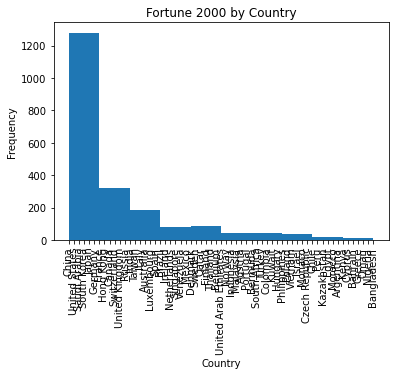

In [842]:
plt.figure()
plt.hist(c2021['Country'])
plt.xlabel('Country')
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.title('Fortune 2000 by Country')
plt.show()

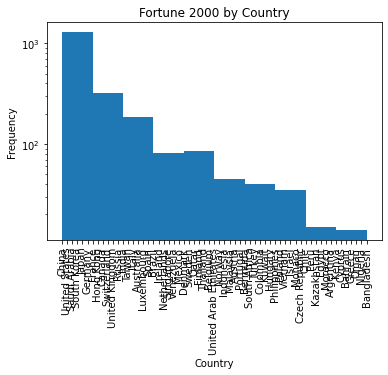

In [843]:
plt.figure()
plt.hist(c2021['Country'], log='True')
plt.xlabel('Country')
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.title('Fortune 2000 by Country')
plt.show()

The pairplots would allow me to identify the two variables with the most correlation.

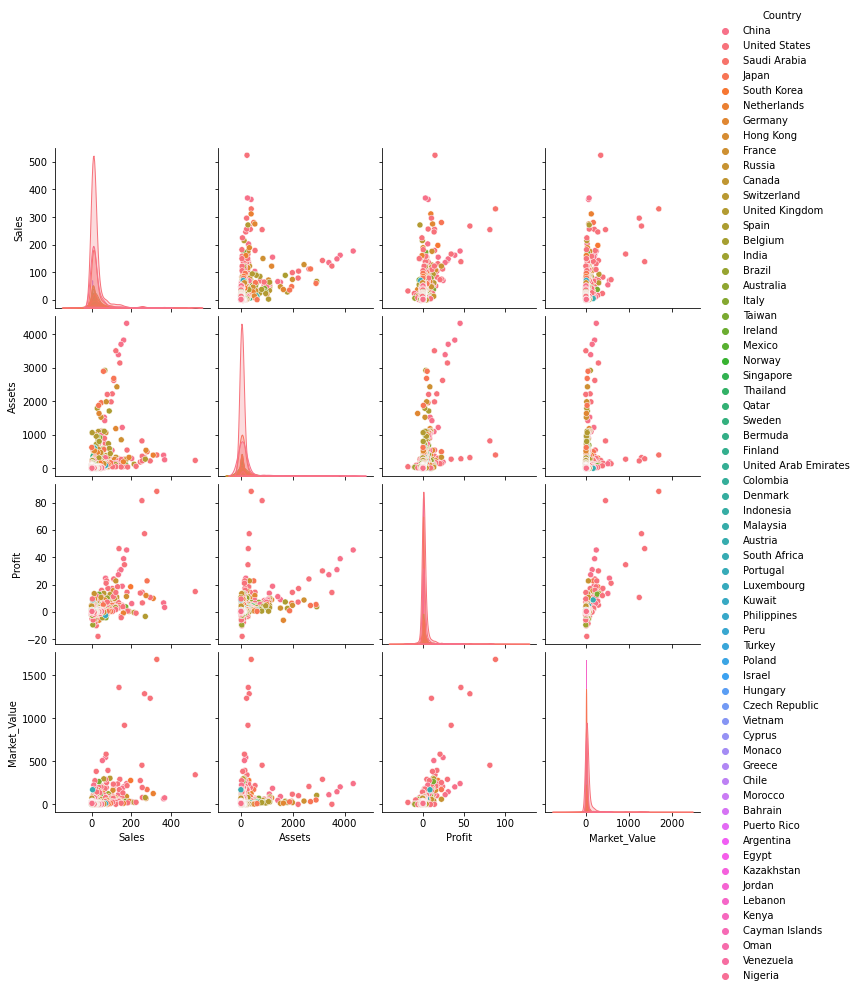

In [844]:
abv_c2020 = c2020[["Country", "Sales", "Assets", "Profit", "Market_Value"]]

sns.pairplot(abv_c2020, hue="Country")

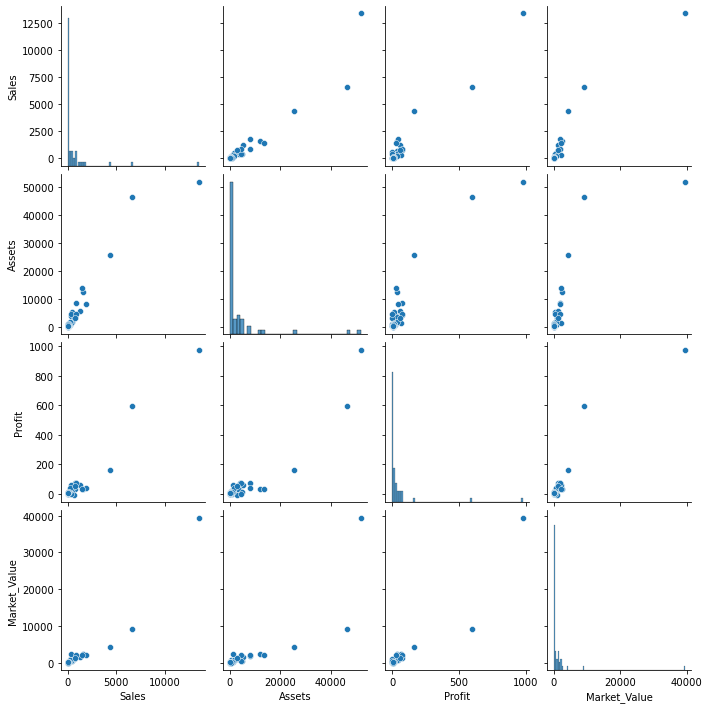

In [845]:
sns.pairplot(grouped_companies)

I thought to expand certain charts by plotting them individually.

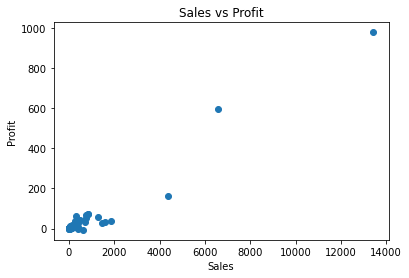

In [846]:
plt.figure()
plt.scatter(grouped_companies['Sales'], grouped_companies['Profit'])
plt.xlabel('Sales')
plt.ylabel('Profit')
plt.title('Sales vs Profit')
plt.show()

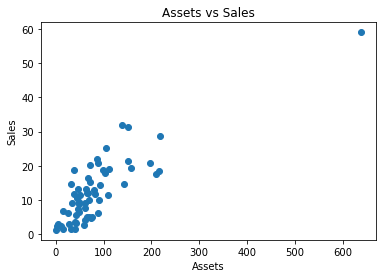

In [847]:
plt.figure()
plt.scatter(grouped_companies_avg['Assets'], grouped_companies_avg['Sales'])
plt.xlabel('Assets')
plt.ylabel('Sales')
plt.title('Assets vs Sales')
plt.show()

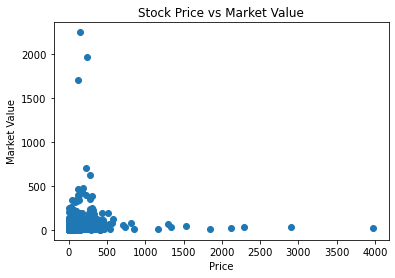

In [848]:
plt.figure()
plt.scatter(company_stocks21['price'], company_stocks21['Market_Value'])
plt.xlabel('Price')
plt.ylabel('Market Value')
plt.title('Stock Price vs Market Value')
plt.show()

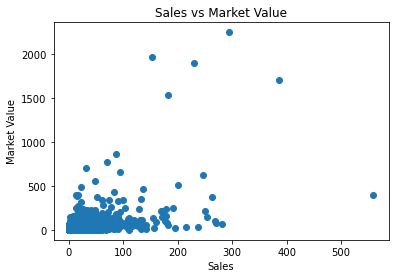

In [849]:
plt.figure()
plt.scatter(c2021['Sales'], c2021['Market_Value'])
plt.xlabel('Sales')
plt.ylabel('Market Value')
plt.title('Sales vs Market Value')
plt.show()

Profit seems to be the variable that correlates most closely to market value so I thought to look into it in further detail (with countries as the hue)

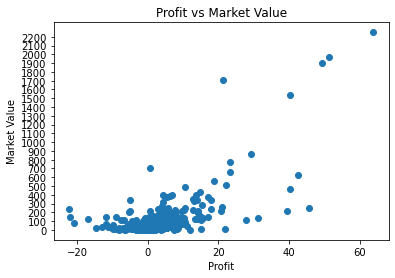

In [850]:
plt.figure()
plt.scatter(c2021['Profit'], c2021['Market_Value'])
plt.xlabel('Profit')
plt.ylabel('Market Value')
plt.yticks(np.arange(min(c2021['Market_Value']), max(c2021['Market_Value'])+1, 100))
plt.title('Profit vs Market Value')
plt.show()

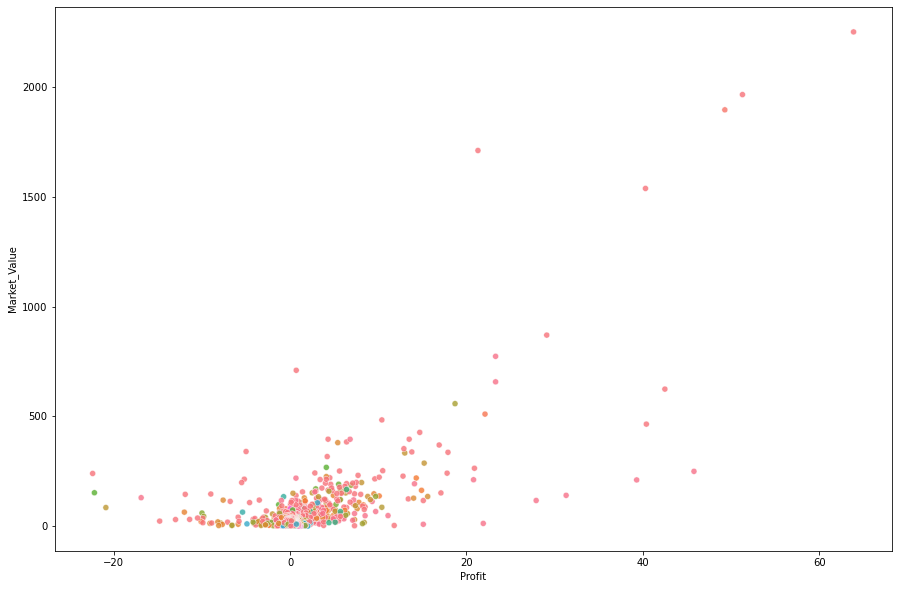

In [851]:
plt.figure(figsize = (15,10))
sns.scatterplot(data=c2021, x='Profit', y='Market_Value', hue='Country', alpha=0.8, ax = matplotlib.pyplot.gca(), legend= False)  
plt.show()

The charts below are here to check whether the market value change is correlated by any other measure changing.

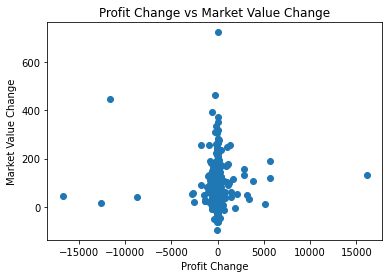

In [852]:
plt.figure()
plt.scatter(historical_summary["Profit_Change"], historical_summary["MV_Change"])
plt.xlabel('Profit Change')
plt.ylabel('Market Value Change')
plt.title('Profit Change vs Market Value Change')
plt.show()

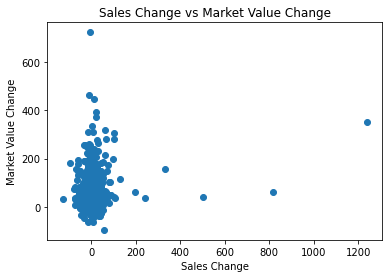

In [853]:
plt.figure()
plt.scatter(historical_summary["Sales_Change"], historical_summary["MV_Change"])
plt.xlabel('Sales Change')
plt.ylabel('Market Value Change')
plt.title('Sales Change vs Market Value Change')
plt.show()

Statistics

In [854]:
c2021.corr()

,Sales,Profit,Assets,Market_Value,Name_Length
Sales,1.000000,0.472314,0.374360,0.510404,-0.087484
Profit,0.472314,1.000000,0.444313,0.701766,-0.009604
Assets,0.374360,0.444313,1.000000,0.157160,0.020185
Market_Value,0.510404,0.701766,0.157160,1.000000,-0.062518
Name_Length,-0.087484,-0.009604,0.020185,-0.062518,1.000000


<AxesSubplot:>

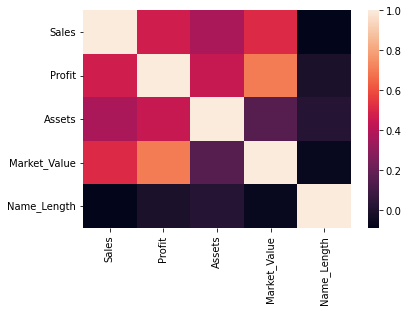

In [855]:
sns.heatmap(c2021.corr())

In [856]:
grouped_companies.corr()

,Sales,Assets,Profit,Market_Value
Sales,1.000000,0.954509,0.973254,0.952897
Assets,0.954509,1.000000,0.931881,0.834159
Profit,0.973254,0.931881,1.000000,0.944218
Market_Value,0.952897,0.834159,0.944218,1.000000


<AxesSubplot:>

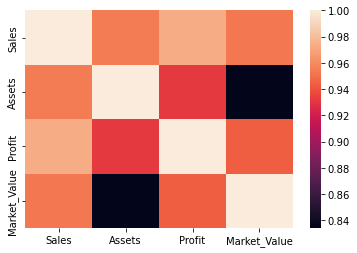

In [857]:
sns.heatmap(grouped_companies.corr())

### Data Modelling

Based on the charts above, I knew what variable I should use for comparisions and which ones would clearly have no relationship. The top ones I looked at were:
- Profit vs Market Value
- Sales vs Profit
- Profit Change vs Market Value Change

Given that we are able to use multiple variable to predict another, I checked the following:
- Profit, Sales, Assets vs Market Value
- Name Length, Stock Price vs Market Value
- Profit Change, Sales Change, Assets Change vs Market Value Change


In [858]:
def covariance(x, y):
    assert len(x) == len(y) # match two variables
    num_of_elements = len(x)
    x_mean = sum(x)/num_of_elements
    y_mean = sum(y)/num_of_elements
    diff = [((xi-x_mean) * (yi-y_mean)) for xi, yi in zip(x, y)]
    return sum(diff)/num_of_elements

In [859]:
covariance(c2021['Profit'], c2021['Market_Value'])

323.44285849218846

In [860]:
np.cov(c2021['Profit'], c2021['Market_Value'])

array([[   17.82438468,   323.59695228],
       [  323.59695228, 11929.14877463]])

Given that the data is not evenly distrubted and that the covariance found above is quite hight, I thought to add a log scale to the data to look for extreme outliers.

/Users/Carlo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


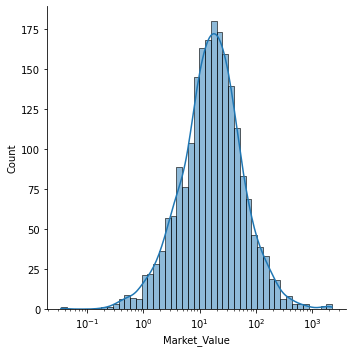

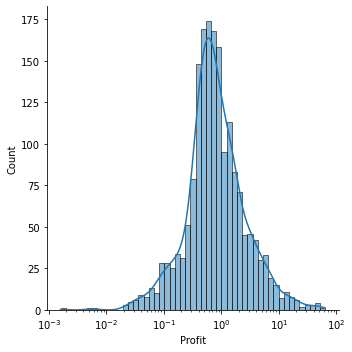

In [861]:
MV = c2021['Market_Value']
P = c2021['Profit']

sns.displot(MV, kde = True, log_scale=True)
sns.displot(P, kde = True, log_scale=True)

In [862]:
x1 = grouped_companies[['Profit', 'Market_Value']]

stats.shapiro(x1)

ShapiroResult(statistic=0.15950053930282593, pvalue=2.4893307346928732e-23)

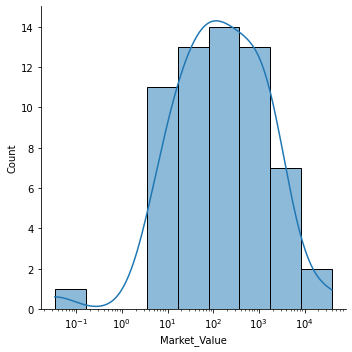

In [863]:
x2 = grouped_companies['Market_Value']

sns.displot(x2, kde = True, log_scale=True)

In [864]:
stats.zscore(MV)

None
1.0        1.933283
2.0        3.904991
3.0        5.366601
4.0        1.575206
5.0       17.022852
            ...    
1976.0    -0.319575
1976.0    -0.266459
1979.0    -0.339723
1979.0    -0.270122
1979.0    -0.131837
Name: Market_Value, Length: 2100, dtype: float64

In [865]:
np.where(abs(stats.zscore(MV)) > 3)

(array([  1,   2,   4,   5,   9,  10,  12,  14,  17,  20,  22,  28,  32,
         33,  63,  65, 121, 240, 255, 261, 263]),)

In [866]:
MV_outliers = MV[[1, 2, 4, 5, 9, 10, 12, 14, 17, 20, 22, 28, 32, 33, 63, 65, 121, 240, 255, 261, 263]]

MV_outliers.sort_values(ascending = False)

None
5.0      1897.2
10.0     1711.8
28.0      773.8
22.0      657.5
2.0       464.8
32.0      427.1
17.0      396.1
20.0      369.6
63.0      352.8
1.0       249.5
12.0      219.2
4.0       210.4
9.0       140.1
65.0      139.8
33.0      137.3
14.0      116.7
255.0      28.0
263.0      27.2
121.0      26.5
261.0      25.9
240.0      12.5
Name: Market_Value, dtype: float64

In [867]:
hsp = historical_summary['Profit_Change']
hsmv = historical_summary['MV_Change']

stats.ttest_ind(hsp, hsmv)

Ttest_indResult(statistic=-4.067323479368588, pvalue=4.8554712093107594e-05)

The chart below shows the concentration of the values when comparing market value change to profit change.

/Users/Carlo/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Profit_Change', ylabel='MV_Change'>

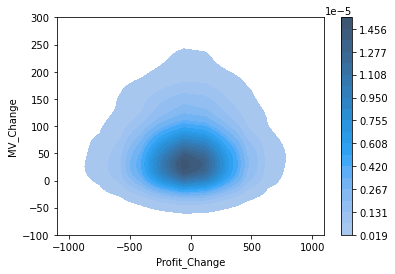

In [868]:
plt.xlim(-1100, 1100)
plt.ylim(-100, 300)
sns.kdeplot(hsp, hsmv, n_levels = 20, shade = True, cbar = True)

In [869]:
stats.ttest_ind(c2020.loc[c2020.Country == 'China', 'Market_Value'],
               c2020.loc[c2020.Country == 'United States', 'Market_Value'])

Ttest_indResult(statistic=-2.9631034727028362, pvalue=0.003130384065298593)

The chart below shows the distribution of market values for different countries.

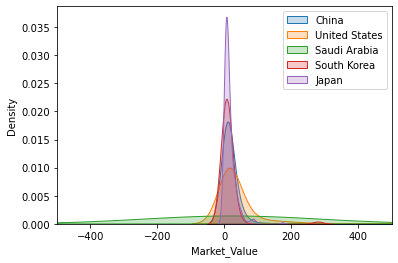

In [870]:
plt.xlim(-500, 500)

sns.kdeplot(c2020.loc[c2020.Country == 'China', 'Market_Value'], label='China', shade=True)
sns.kdeplot(c2020.loc[c2020.Country == 'United States', 'Market_Value'], label='United States', shade=True)
sns.kdeplot(c2020.loc[c2020.Country == 'Saudi Arabia', 'Market_Value'], label='Saudi Arabia', shade=True)
sns.kdeplot(c2020.loc[c2020.Country == 'South Korea', 'Market_Value'], label='South Korea', shade=True)
sns.kdeplot(c2020.loc[c2020.Country == 'Japan', 'Market_Value'], label='Japan', shade=True)
plt.legend()
plt.show()

In [871]:
df = pd.DataFrame(dict(x = c2021["Profit"], y = c2021["Market_Value"]))

This is the first attempt at making some type of prediction, this is done by trying to find the line of best fit with the least "loss".

In [872]:
yhat_1 = 10 + 2 * df["x"]
yhat_2 = 20 + df["x"]
yhat_3 = 30 + 12 * df["x"]

df = df.assign(yhat_1=yhat_1)
df = df.assign(yhat_2=yhat_2)
df = df.assign(yhat_3=yhat_3)

model_1_loss = ((df["yhat_1"] - df["y"]) ** 2).sum()
model_2_loss = ((df["yhat_2"] - df["y"]) ** 2).sum()
model_3_loss = ((df["yhat_3"] - df["y"]) ** 2).sum()

print("Model 1 (y=1+4x) loss: " + str(model_1_loss))
print("Model 2 (y=2+3x) loss: " + str(model_2_loss))
print("Model 3 (y=1+1.8x) loss: " + str(model_3_loss))

Model 1 (y=1+4x) loss: 23888828.859316364
Model 2 (y=2+3x) loss: 24338430.95665599
Model 3 (y=1+1.8x) loss: 14204274.922830962


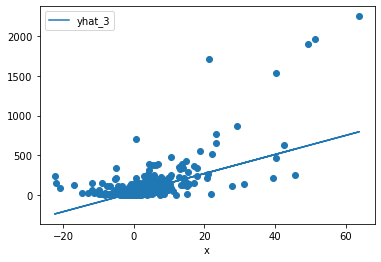

In [873]:
df.plot(x="x", y="yhat_3")
plt.scatter(df["x"], df["y"])

In [874]:
df_2 = pd.DataFrame(dict(x_1 = grouped_companies["Sales"], y_1 = grouped_companies["Profit"]))

yhat_1 = 10 + 0.074 * df_2["x_1"]
yhat_2 = -10 + 0.053 * df_2["x_1"]
yhat_3 = -10 + 0.07 * df_2["x_1"]

df_2 = df_2.assign(yhat_1=yhat_1)
df_2 = df_2.assign(yhat_2=yhat_2)
df_2 = df_2.assign(yhat_3=yhat_3)

model_1_loss = ((df_2["yhat_1"] - df_2["y_1"]) ** 2).sum()
model_2_loss = ((df_2["yhat_2"] - df_2["y_1"]) ** 2).sum()
model_3_loss = ((df_2["yhat_3"] - df_2["y_1"]) ** 2).sum()

print("Model 1 (y=10+0.074x) loss: " + str(model_1_loss))
print("Model 2 (y=-10+0.053x) loss: " + str(model_2_loss))
print("Model 3 (y=-10+0.07x) loss: " + str(model_3_loss))

Model 1 (y=10+0.074x) loss: 85592.31330194272
Model 2 (y=-10+0.053x) loss: 168115.44457063745
Model 3 (y=-10+0.07x) loss: 69739.22006259211


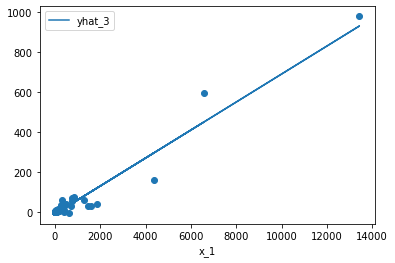

In [875]:
df_2.plot(x="x_1", y="yhat_3")
plt.scatter(df_2["x_1"], df_2["y_1"])

In [876]:
np.cov(df_2["y_1"], df_2["x_1"])

array([[  21117.65233242,  277467.04092287],
       [ 277467.04092287, 3848796.84860691]])

In [877]:
beta_1 = np.cov(df_2["y_1"], df_2["x_1"])[0, 1] / np.cov(df_2["y_1"], df_2["x_1"])[1, 1]
beta_0 = np.mean(df_2["y_1"]) - beta_1 * np.mean(df_2["x_1"])

print("beta_0 = " + str(beta_0))
print("beta_1 = " + str(beta_1))

# add the new yhat to the dataframe
df_2["yhat"] = beta_0 + beta_1 * df_2["x_1"]

# Compute the sum of squares
print("Sum of squared errors = " + str(sum((df_2["y_1"] - df_2["yhat"]) ** 2)))

beta_0 = -5.8621452262176845
beta_1 = 0.07209189048866074
Sum of squared errors = 66871.72823992118


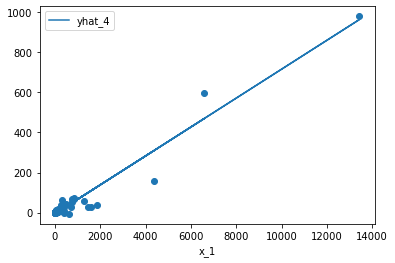

In [878]:
df_2["yhat_4"] = beta_0 + beta_1 * df_2["x_1"]
df_2.plot(x="x_1", y="yhat_4")
plt.scatter(df_2["x_1"], df_2["y_1"])

In [879]:
def calculate_coefs(X,Y):
    theta = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, Y))
    return theta


def error(X, Y, thetas):
    yhat = np.dot(X, thetas.T)
    err = np.sum(np.power(Y - yhat, 2))
    return err

def calculate_coefs_new(x, y):
    theta = (np.linalg.inv(X.T @ X)) @ (X.T @ Y)
    return theta

In [880]:
df_2["ones"] = 1

In [881]:
X, Y = df_2[['x_1', 'ones']].values, df_2['y_1'].values

In [882]:
coefs = calculate_coefs(X, Y)
print(coefs)

[ 0.07209189 -5.86214523]


In [883]:
err = error(X, Y, coefs)
print(err)

66871.72823992121


This is the start of multiple tests on different variables.

In [884]:
model = smf.ols(data = df, formula = "y ~ x")
result = model.fit()

In [885]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     2036.
Date:                Tue, 15 Nov 2022   Prob (F-statistic):          2.62e-311
Time:                        22:29:26   Log-Likelihood:                -12123.
No. Observations:                2100   AIC:                         2.425e+04
Df Residuals:                    2098   BIC:                         2.426e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.4154      1.767      9.291      0.000      12.951      19.880
x             18.1547      0.402     45.120      0.000      17.366      18.944
==============================================================================
Omnibus:                     2736.692   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           843129.794
Skew:                           6.890   Prob(JB):                         0.00
Kurtosis:                     100.190   Cond. No.                         4.59
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [886]:
model = smf.ols(data = df_2, formula = "y_1 ~ x_1")
result = model.fit() 

In [887]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    y_1   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     1059.
Date:                Tue, 15 Nov 2022   Prob (F-statistic):           2.18e-39
Time:                        22:29:28   Log-Likelihood:                -300.04
No. Observations:                  61   AIC:                             604.1
Df Residuals:                      59   BIC:                             608.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.8621      4.551     -1.288      0.203     -14.969       3.245
x_1            0.0721      0.002     32.541      0.000       0.068       0.077
==============================================================================
Omnibus:                       35.854   Durbin-Watson:                   1.747
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              225.098
Skew:                          -1.299   Prob(JB):                     1.32e-49
Kurtosis:                      12.045   Cond. No.                     2.17e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [888]:
r2_score(c2021['Profit'], c2021['Market_Value'])

-710.5631931493951

In [889]:
r2_score(grouped_companies['Sales'], grouped_companies['Profit'])

0.03787739343703633

In [890]:
c2021_reg = smf.ols("Market_Value ~ Profit + Sales + Assets", data=c2021).fit()
c2021_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Market_Value   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     972.7
Date:                Tue, 15 Nov 2022   Prob (F-statistic):               0.00
Time:                        22:29:30   Log-Likelihood:                -11920.
No. Observations:                2100   AIC:                         2.385e+04
Df Residuals:                    2096   BIC:                         2.387e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.2233      1.782      4.614      0.000       4.728      11.718
Profit        17.5741      0.439     40.064      0.000      16.714      18.434
Sales          0.9175      0.053     17.302      0.000       0.814       1.022
Assets        -0.0809      0.005    -15.559      0.000      -0.091      -0.071
==============================================================================
Omnibus:                     2406.695   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           413010.282
Skew:                           5.603   Prob(JB):                         0.00
Kurtosis:                      70.783   Cond. No.                         411.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [891]:
grouped_companies_reg = smf.ols("Market_Value ~ Profit + Sales + Assets", data=grouped_companies).fit()
grouped_companies_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Market_Value   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     885.1
Date:                Tue, 15 Nov 2022   Prob (F-statistic):           9.42e-48
Time:                        22:29:31   Log-Likelihood:                -489.56
No. Observations:                  61   AIC:                             987.1
Df Residuals:                      57   BIC:                             995.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     64.1066    107.717      0.595      0.554    -151.593     279.806
Profit        12.9523      2.963      4.372      0.000       7.019      18.885
Sales          3.7191      0.267     13.929      0.000       3.184       4.254
Assets        -0.4697      0.035    -13.341      0.000      -0.540      -0.399
==============================================================================
Omnibus:                       13.492   Durbin-Watson:                   2.239
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               30.960
Skew:                           0.539   Prob(JB):                     1.89e-07
Kurtosis:                       6.320   Cond. No.                     1.13e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [892]:
company_stocks21_reg = smf.ols("Market_Value ~ price + Name_Length + Profit", data=company_stocks21).fit()
company_stocks21_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Market_Value   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     305.0
Date:                Tue, 15 Nov 2022   Prob (F-statistic):          1.56e-143
Time:                        22:29:32   Log-Likelihood:                -6413.7
No. Observations:                1088   AIC:                         1.284e+04
Df Residuals:                    1084   BIC:                         1.286e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      41.8434      6.184      6.766      0.000      29.709      53.977
price           0.0227      0.012      1.873      0.061      -0.001       0.047
Name_Length    -1.6682      0.435     -3.833      0.000      -2.522      -0.814
Profit         16.8165      0.564     29.821      0.000      15.710      17.923
==============================================================================
Omnibus:                     1479.121   Durbin-Watson:                   2.357
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           446241.384
Skew:                           7.222   Prob(JB):                         0.00
Kurtosis:                     101.158   Cond. No.                         553.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [893]:
historical_summary_reg = smf.ols("MV_Change ~ Sales_Change + Profit_Change + Assets_Change", data=historical_summary).fit()
historical_summary_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              MV_Change   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     8.610
Date:                Tue, 15 Nov 2022   Prob (F-statistic):           1.13e-05
Time:                        22:29:33   Log-Likelihood:                -9987.7
No. Observations:                1837   AIC:                         1.998e+04
Df Residuals:                    1833   BIC:                         2.001e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        52.1674      1.300     40.131      0.000      49.618      54.717
Sales_Change      0.1519      0.030      5.033      0.000       0.093       0.211
Profit_Change    -0.0006      0.002     -0.363      0.717      -0.004       0.003
Assets_Change    -0.0002      0.000     -0.501      0.616      -0.001       0.001
==============================================================================
Omnibus:                     1167.559   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24701.992
Skew:                           2.617   Prob(JB):                         0.00
Kurtosis:                      20.185   Cond. No.                     2.80e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [894]:
new_c2021 = c2021[["Name", "Sales", "Assets", "Profit"]]

new_c2021['predicted_MV'] = c2021_reg.predict(new_c2021)
new_c2021

/var/folders/2f/gq2c3rh91jgdf1_btrz5_2240000gn/T/ipykernel_41194/2951993197.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_c2021['predicted_MV'] = c2021_reg.predict(new_c2021)


,Name,Sales,Assets,Profit,predicted_MV
None,,,,,
1.0,ICBC,190.500,4914.7,45.8000,590.186096
2.0,JPMorgan Chase,136.200,3689.3,40.4000,544.628912
3.0,Berkshire Hathaway,245.500,873.7,42.5000,909.674869
4.0,China Construction Bank,173.500,4301.7,39.3000,509.963374
5.0,Saudi Arabian Oil Company (Saudi Aramco),229.700,510.3,49.3000,1044.089548
...,...,...,...,...,...
1976.0,JTEKT,13.100,12.0,-0.0349,18.658669
1976.0,Insurance Australia Group,5.400,25.0,-0.2120,7.429171
1979.0,Sumec Corporation,13.000,7.1,0.0792,20.968650


The charts below demonstrate what the predicted market value would be given a certain measure in the data.

<AxesSubplot:title={'center':'Estimated Market Value of a Company'}, xlabel='Profit', ylabel='predicted_MV'>

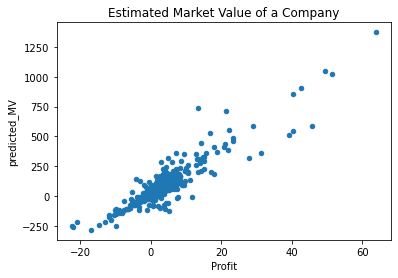

In [895]:
new_c2021.plot.scatter(x='Profit', y='predicted_MV', title='Estimated Market Value of a Company')

In [896]:
new_grouped_companies = grouped_companies[["Sales", "Assets", "Profit"]]

new_grouped_companies['predicted_MV'] = grouped_companies_reg.predict(new_grouped_companies)
new_grouped_companies

,Sales,Assets,Profit,predicted_MV
Country,,,,
Argentina,13.500,29.400,-0.9823,87.781018
Australia,385.903,3691.600,29.4348,146.524488
Austria,91.200,812.200,4.4889,79.918000
Bahrain,1.700,40.100,0.4186,57.015023
Bangladesh,1.300,0.510,1.2000,84.244604
...,...,...,...,...
United Arab Emirates,57.000,788.400,10.6584,43.814890
United Kingdom,1443.711,13646.400,28.1580,-611.952867
United States,13429.249,52006.781,978.6523,38255.291581


<AxesSubplot:title={'center':'Estimated Market Value of a Company'}, xlabel='Profit', ylabel='predicted_MV'>

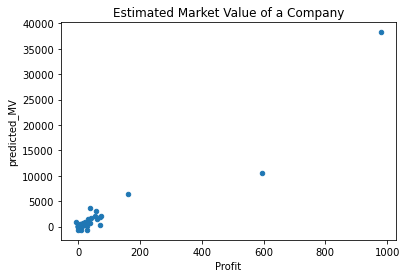

In [897]:
new_grouped_companies.plot.scatter(x='Profit', y='predicted_MV', title='Estimated Market Value of a Company')

In [898]:
new_company_stocks21 = company_stocks21[["Name","price", "Profit", "Name_Length"]]

new_company_stocks21['predicted_MV'] = company_stocks21_reg.predict(new_company_stocks21)
new_company_stocks21

/var/folders/2f/gq2c3rh91jgdf1_btrz5_2240000gn/T/ipykernel_41194/512120599.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_company_stocks21['predicted_MV'] = company_stocks21_reg.predict(new_company_stocks21)


,Name,price,Profit,Name_Length,predicted_MV
0,ICBC,0.47,45.8000,4,805.377799
1,JPMorgan Chase,116.51,40.4000,14,700.524539
2,Berkshire Hathaway,278.34,42.5000,18,732.845001
3,China Construction Bank,0.76,39.3000,23,664.381784
4,Apple,143.86,63.9000,5,1111.347880
...,...,...,...,...,...
1083,Insurance Australia Group,3.04,-0.2120,25,-3.356907
1084,Gold Fields,7.51,0.7181,11,35.740136
1085,Gold Fields,7.51,0.7181,11,35.740136
1086,Paycom,320.50,0.1434,6,41.530936


<AxesSubplot:title={'center':'Estimated Market Value of a Company'}, xlabel='Profit', ylabel='predicted_MV'>

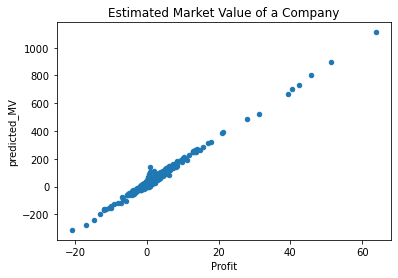

In [899]:
new_company_stocks21.plot.scatter(x='Profit', y='predicted_MV', title='Estimated Market Value of a Company')

In [900]:
new_historical_summary = historical_summary[["Name", "Sales_Change", "Assets_Change", "Profit_Change"]]

new_historical_summary['predicted_MV_Change'] = historical_summary_reg.predict(new_historical_summary)
new_historical_summary

,Name,Sales_Change,Assets_Change,Profit_Change,predicted_MV_Change
0,ICBC,7.505643,13.700405,1.103753,53.303295
1,China Construction Bank,7.032696,12.551020,1.028278,53.231788
2,JPMorgan Chase,-4.688593,17.516086,34.666667,51.430659
3,Berkshire Hathaway,-3.574234,6.848477,-47.788698,51.651483
4,Agricultural Bank of China,3.496974,12.505747,1.294498,52.694724
...,...,...,...,...,...
1832,Indorama Ventures,-7.017544,18.897638,-61.449275,51.133926
1833,L Brands,-8.527132,14.851485,-330.956284,51.066163
1834,Slack Technologies,43.333333,71.428571,-47.390543,58.759319
1835,Slack Technologies,43.333333,71.428571,-47.390543,58.759319


<AxesSubplot:title={'center':'Estimated Market Value of a Company'}, xlabel='Sales_Change', ylabel='predicted_MV_Change'>

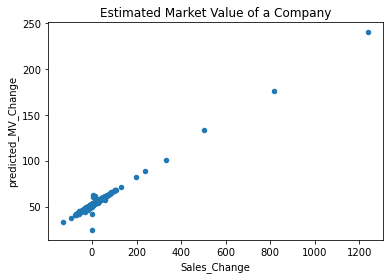

In [901]:
new_historical_summary.plot.scatter(x='Sales_Change', y='predicted_MV_Change', title='Estimated Market Value of a Company')

In [902]:
c2021.Country.value_counts()

United States     611
China             307
Japan             229
United Kingdom     69
Hong Kong          64
                 ... 
Kenya               1
Egypt               1
Czech Republic      1
Monaco              1
Bangladesh          1
Name: Country, Length: 61, dtype: int64

This is the first attempt at getting classification to work for my project by looking into countries.

In [903]:
pd.get_dummies(c2021, columns=["Country"])

,Name,Sales,Profit,Assets,Market_Value,Name_Length,Country_Argentina,Country_Australia,Country_Austria,Country_Bahrain,...,Country_Sweden,Country_Switzerland,Country_Taiwan,Country_Thailand,Country_Turkey,Country_United Arab Emirates,Country_United Kingdom,Country_United States,Country_Venezuela,Country_Vietnam
None,,,,,,,,,,,,,,,,,,,,,
1.0,ICBC,190.500,45.8000,4914.7,249.5,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2.0,JPMorgan Chase,136.200,40.4000,3689.3,464.8,14,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3.0,Berkshire Hathaway,245.500,42.5000,873.7,624.4,18,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4.0,China Construction Bank,173.500,39.3000,4301.7,210.4,23,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5.0,Saudi Arabian Oil Company (Saudi Aramco),229.700,49.3000,510.3,1897.2,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1976.0,JTEKT,13.100,-0.0349,12.0,3.5,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1976.0,Insurance Australia Group,5.400,-0.2120,25.0,9.3,25,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1979.0,Sumec Corporation,13.000,0.0792,7.1,1.3,17,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [904]:
c2021_reg_country = smf.ols("Market_Value ~ Sales + Profit + Assets + Country", data=c2021).fit()
c2021_reg_country.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Market_Value   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     48.82
Date:                Tue, 15 Nov 2022   Prob (F-statistic):               0.00
Time:                        22:29:41   Log-Likelihood:                -11869.
No. Observations:                2100   AIC:                         2.387e+04
Df Residuals:                    2036   BIC:                         2.423e+04
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          44.7673     49.493      0.905      0.366     -52.294     141.829
Country[T.Australia]              -25.9963     50.928     -0.510      0.610    -125.873      73.880
Country[T.Austria]                -45.5621     54.715     -0.833      0.405    -152.865      61.741
Country[T.Bahrain]                -43.2503     85.721     -0.505      0.614    -211.361     124.860
Country[T.Bangladesh]             -66.9804     85.724     -0.781      0.435    -235.097     101.136
Country[T.Belgium]                -31.6602     54.715     -0.579      0.563    -138.964      75.644
Country[T.Bermuda]                -54.3668     57.149     -0.951      0.342    -166.443      57.709
Country[T.Brazil]                 -46.0419     51.694     -0.891      0.373    -147.420      55.336
Country[T.Canada]                 -35.3305     50.341     -0.702      0.483    -134.056      63.395
Country[T.Chile]                  -46.7900     58.558     -0.799      0.424    -161.630      68.050
Country[T.China]                  -56.3641     49.660     -1.135      0.257    -153.754      41.026
Country[T.Colombia]               -41.0593     63.892     -0.643      0.521    -166.361      84.242
Country[T.Cyprus]                 -56.1663     85.723     -0.655      0.512    -224.281     111.948
Country[T.Czech Republic]         -39.5769     85.720     -0.462      0.644    -207.685     128.531
Country[T.Denmark]                -31.5736     53.460     -0.591      0.555    -136.416      73.269
Country[T.Egypt]                  -51.5655     85.722     -0.602      0.548    -219.677     116.546
Country[T.Finland]                -34.9810     54.716     -0.639      0.523    -142.287      72.325
Country[T.France]                 -18.9238     50.381     -0.376      0.707    -117.728      79.880
Country[T.Germany]                -38.7306     50.350     -0.769      0.442    -137.474      60.012
Country[T.Greece]                 -40.5123     57.148     -0.709      0.478    -152.586      71.562
Country[T.Hong Kong]              -49.3925     50.261     -0.983      0.326    -147.961      49.176
Country[T.Hungary]                -47.5956     69.990     -0.680      0.497    -184.856      89.665
Country[T.India]                  -36.6176     50.384     -0.727      0.467    -135.426      62.191
Country[T.Indonesia]              -41.5113     57.150     -0.726      0.468    -153.589      70.567
Country[T.Ireland]                -23.0889     52.170     -0.443      0.658    -125.401      79.223
Country[T.Israel]                 -37.2075     53.162     -0.700      0.484    -141.465      67.050
Country[T.Italy]                  -32.1030     51.519     -0.623      0.533    -133.139      68.933
Country[T.Japan]                  -46.3699     49.710     -0.933      0.351    -143

In [905]:
c2021_reg_country.predict({
    'Sales' : 100,
    'Profit' : 10,
    'Assets' : 1000,
    'Country' : 'United States'
})

0    208.809141
dtype: float64

In [906]:
c2021_reg_country.predict({
    'Sales' : 100,
    'Profit' : 10,
    'Assets' : 1000,
    'Country' : 'China'
})

0    173.642879
dtype: float64

   Profit  linear_prediction  quadratic_prediction  cubic_prediction  \
0     -30        -528.226553            207.805309        262.403125   
1     -20        -346.679219             61.617205         82.708616   
2     -10        -165.131885             -0.179416          4.148067   
3       0          16.415450             22.415445         22.103330   
4      10         197.962784            129.401789        131.956257   

   quartic_prediction  quintic_prediction  
0          770.071132          586.155328  
1          190.818359          178.958165  
2           -6.901543            4.296429  
3           18.831346           19.079354  
4          157.459686          158.347884  


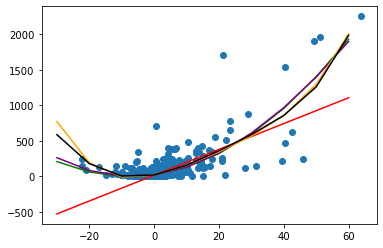

In [907]:
c2021_poly1 = smf.ols("Market_Value ~ Profit", data = c2021).fit()
c2021_poly2 = smf.ols("Market_Value ~ Profit + np.power(Profit, 2)", data = c2021).fit()
c2021_poly3 = smf.ols("Market_Value ~ Profit + np.power(Profit, 2) + np.power(Profit, 3)", data = c2021).fit()
c2021_poly4 = smf.ols("Market_Value ~ Profit + np.power(Profit, 2) + np.power(Profit, 3) + np.power(Profit, 4)", data = c2021).fit()
c2021_poly5 = smf.ols("Market_Value ~ Profit + np.power(Profit, 2) + np.power(Profit, 3) + np.power(Profit, 4) + np.power(Profit, 5)", data = c2021).fit()

profit_df = pd.DataFrame({'Profit': np.arange(-30, 70, 10)})
profit_df['linear_prediction'] = c2021_poly1.predict(profit_df)
profit_df['quadratic_prediction'] = c2021_poly2.predict(profit_df)
profit_df['cubic_prediction'] = c2021_poly3.predict(profit_df)
profit_df['quartic_prediction'] = c2021_poly4.predict(profit_df)
profit_df['quintic_prediction'] = c2021_poly5.predict(profit_df)
print(profit_df.head())
plt.scatter(c2021['Profit'], c2021['Market_Value'])
plt.plot(profit_df['Profit'], profit_df['linear_prediction'], color = 'red')
plt.plot(profit_df['Profit'], profit_df['quadratic_prediction'], color='green')
plt.plot(profit_df['Profit'], profit_df['cubic_prediction'], color = 'purple')
plt.plot(profit_df['Profit'], profit_df['quartic_prediction'], color = 'orange')
plt.plot(profit_df['Profit'], profit_df['quintic_prediction'], color = 'black')

The following regression results are returning values for differeny degree polynomials.

In [908]:
c2021_poly1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Market_Value   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     2036.
Date:                Tue, 15 Nov 2022   Prob (F-statistic):          2.62e-311
Time:                        22:29:44   Log-Likelihood:                -12123.
No. Observations:                2100   AIC:                         2.425e+04
Df Residuals:                    2098   BIC:                         2.426e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.4154      1.767      9.291      0.000      12.951      19.880
Profit        18.1547      0.402     45.120      0.000      17.366      18.944
==============================================================================
Omnibus:                     2736.692   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           843129.794
Skew:                           6.890   Prob(JB):                         0.00
Kurtosis:                     100.190   Cond. No.                         4.59
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [909]:
c2021_poly2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Market_Value   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     1926.
Date:                Tue, 15 Nov 2022   Prob (F-statistic):               0.00
Time:                        22:29:46   Log-Likelihood:                -11741.
No. Observations:                2100   AIC:                         2.349e+04
Df Residuals:                    2097   BIC:                         2.350e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              22.4154      1.486     15.084      0.000      19.501      25.330
Profit                  6.4791      0.510     12.698      0.000       5.478       7.480
np.power(Profit, 2)     0.4220      0.014     30.365      0.000       0.395       0.449
==============================================================================
Omnibus:                     2054.484   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1738238.665
Skew:                           3.662   Prob(JB):                         0.00
Kurtosis:                     143.755   Cond. No.                         165.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [910]:
c2021_poly3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Market_Value   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     1285.
Date:                Tue, 15 Nov 2022   Prob (F-statistic):               0.00
Time:                        22:29:47   Log-Likelihood:                -11740.
No. Observations:                2100   AIC:                         2.349e+04
Df Residuals:                    2096   BIC:                         2.351e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              22.1033      1.504     14.695      0.000      19.154      25.053
Profit                  6.4674      0.510     12.675      0.000       5.467       7.468
np.power(Profit, 2)     0.4595      0.031     14.646      0.000       0.398       0.521
np.power(Profit, 3)    -0.0008      0.001     -1.334      0.182      -0.002       0.000
==============================================================================
Omnibus:                     1989.210   Durbin-Watson:                   1.851
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1711177.942
Skew:                           3.436   Prob(JB):                         0.00
Kurtosis:                     142.675   Cond. No.                     8.45e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [911]:
logmodel = smf.ols("np.log(Market_Value) ~ np.log(Profit)", c2021).fit()
logmodel.summary()

/Users/Carlo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     np.log(Market_Value)   R-squared:                       0.432
Model:                              OLS   Adj. R-squared:                  0.431
Method:                   Least Squares   F-statistic:                     1355.
Date:                  Tue, 15 Nov 2022   Prob (F-statistic):          3.00e-221
Time:                          22:29:48   Log-Likelihood:                -2479.1
No. Observations:                  1787   AIC:                             4962.
Df Residuals:                      1785   BIC:                             4973.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.9659      0.023    126.739      0.000       2.920       3.012
np.log(Profit)     0.7110      0.019     36.817      0.000       0.673       0.749
==============================================================================
Omnibus:                      129.583   Durbin-Watson:                   1.846
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              534.490
Skew:                          -0.217   Prob(JB):                    8.65e-117
Kurtosis:                       5.644   Cond. No.                         1.32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/Users/Carlo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Carlo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


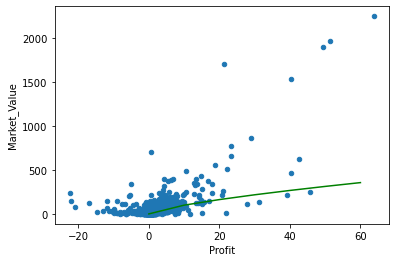

In [912]:
c2021.plot.scatter(x='Profit', y='Market_Value')
plt.plot(np.arange(-30, 70, 10), np.exp(logmodel.predict(pd.DataFrame({'Profit': np.arange(-30, 70, 10)}))), color = 'green')

The following are tests to see whether the models are doing a good job at predicting the market value.

In [913]:
x = c2020['Profit']
y = c2020['Market_Value']

In [914]:
train1, test1 = model_selection.train_test_split(c2020, random_state=44)

In [915]:
len(test1) / (len(train1) + len(test1))

0.25

In [916]:
slope, intercept, r_value, p_value, slope_std_error = stats.linregress(train1.index, train1['Market_Value'])

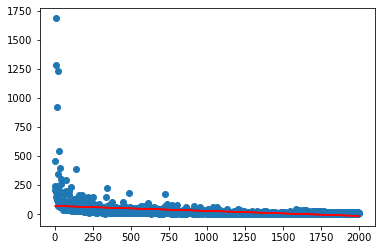

In [917]:
train_regr1 = intercept + slope * train1.index

plt.scatter(train1.index, train1['Market_Value'])
plt.plot(train1.index, train_regr1, color='red')

In [918]:
metrics.r2_score(train1['Market_Value'], train_regr1)

0.10456234918433538

In [919]:
metrics.r2_score(test1['Market_Value'], intercept + slope*test1.index)

0.13024917358176147

In [920]:
metrics.mean_absolute_error(train1['Market_Value'], train_regr1)

24.508929450214723

In [921]:
metrics.mean_absolute_error(test1['Market_Value'], intercept + slope*test1.index)

27.020575874211463

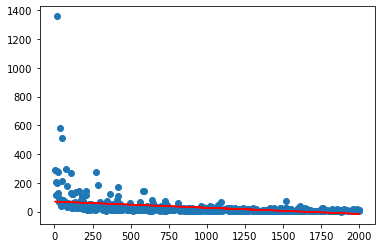

In [922]:
train_regr1 = intercept + slope * train1.index

plt.scatter(test1.index, test1["Market_Value"])
plt.plot(test1.index, intercept + slope * test1.index, color="red");

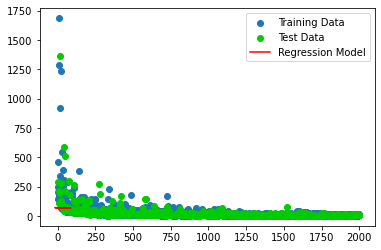

In [923]:
plt.scatter(train1.index, train1["Market_Value"], label="Training Data")
plt.scatter(test1.index, test1["Market_Value"], color="#00CC00", label="Test Data")
plt.plot(x, intercept + slope * x, color="red", label="Regression Model")
plt.legend();

In [924]:
print("R-squared value is", metrics.r2_score(y, intercept + slope * x))
print("MAE is", metrics.mean_absolute_error(y, intercept + slope * x))
print("Mean and std are", c2020["Market_Value"].mean(), c2020["Market_Value"].std())

R-squared value is -0.29684532613790293
MAE is 59.3495994807285
Mean and std are 27.150289999999938 78.26601053830893


In [925]:
x = historical_summary['Sales_Change']
y = historical_summary['MV_Change']

In [926]:
train2, test2 = model_selection.train_test_split(historical_summary, random_state=44)

len(test2) / (len(train2) + len(test2))

0.25040827436037016

In [927]:
slope, intercept, r_value, p_value, slope_std_error = stats.linregress(train2.index, train2['MV_Change'])

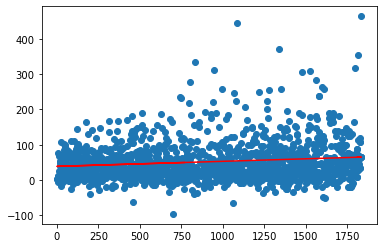

In [928]:
train_regr2 = intercept + slope * train2.index

plt.scatter(train2.index, train2['MV_Change'])
plt.plot(train2.index, train_regr2, color='red')

In [929]:
metrics.r2_score(train2['MV_Change'], train_regr2)

0.018860356277203505

In [930]:
metrics.r2_score(test2['MV_Change'], intercept + slope*test2.index)

0.012409573667430673

In [931]:
metrics.mean_absolute_error(train2['MV_Change'], train_regr2)

39.37056593552289

In [932]:
metrics.mean_absolute_error(test2['MV_Change'], intercept + slope*test2.index)

35.58686206525038

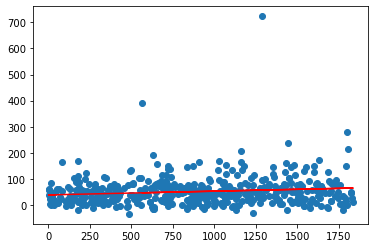

In [933]:
train_regr2 = intercept + slope * train2.index

plt.scatter(test2.index, test2["MV_Change"])
plt.plot(test2.index, intercept + slope * test2.index, color="red");

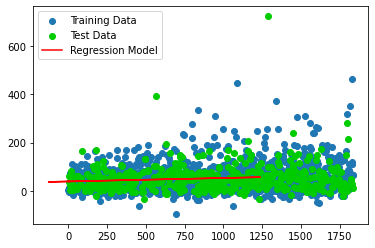

In [934]:
plt.scatter(train2.index, train2["MV_Change"], label="Training Data")
plt.scatter(test2.index, test2["MV_Change"], color="#00CC00", label="Test Data")
plt.plot(x, intercept + slope * x, color="red", label="Regression Model")
plt.legend();

In [935]:
print("R-squared value is", metrics.r2_score(y, intercept + slope * x))
print("MAE is", metrics.mean_absolute_error(y, intercept + slope * x))
print("Mean and std are", historical_summary["MV_Change"].mean(), historical_summary["MV_Change"].std())

R-squared value is -0.05623490984937751
MAE is 37.64020728533061
Mean and std are 52.302812998300745 55.99784748898526


### Cross Validation Attempt

I tried to put together modeling for cross validation to see if there would be better results from doing this rather than just having one sample. There is no significant difference in the R2 Score and the Mean Absolute Error when comparing the cross validation menthod to the one used beforehand so there was no reason to attempt further analysis through it.

In [936]:
x = c2020["Profit"]
y = c2020["Market_Value"]

df = pd.DataFrame({'Market_Value' : y, 'Profit' : x})
df

,Market_Value,Profit
1,242.3,45.300
2,203.8,38.900
3,291.7,30.000
4,455.4,81.400
5,147.2,30.900
...,...,...
1996,8.3,0.115
1997,4.3,0.631
1998,11.8,0.371
1999,11.3,0.305


In [937]:
kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=20)

In [938]:
for train, test in kf.split(df):
    print(train, test)

[   0    1    2 ... 1997 1998 1999] [   9   13   18   56   58   65   74   83   89  105  110  115  116  128
  136  139  141  163  187  200  204  216  222  249  250  255  257  265
  266  269  279  292  302  309  313  328  345  359  371  380  403  407
  412  416  420  422  427  438  447  460  476  486  487  496  506  509
  524  543  553  557  581  604  611  613  635  644  647  659  673  683
  687  708  709  714  721  723  726  734  749  756  760  762  768  772
  788  803  805  807  812  815  826  840  854  855  856  877  901  906
  907  911  925  942  945  960  964 1013 1015 1023 1044 1049 1050 1056
 1077 1092 1095 1143 1144 1180 1182 1188 1192 1215 1238 1243 1257 1262
 1266 1272 1281 1296 1309 1317 1323 1334 1342 1343 1357 1372 1382 1394
 1398 1401 1403 1411 1419 1420 1427 1430 1433 1443 1454 1522 1544 1545
 1546 1547 1556 1559 1560 1569 1575 1586 1594 1596 1606 1611 1630 1631
 1638 1669 1682 1690 1697 1703 1712 1719 1722 1723 1741 1750 1764 1765
 1787 1788 1800 1826 1843 1865 1866 1869 

In [939]:
set1, set2, set3, set4, set5, set6, set7, set8, set9, set10 = kf.split(df)

In [940]:
set1

(array([   0,    1,    2, ..., 1997, 1998, 1999]),
 array([   9,   13,   18,   56,   58,   65,   74,   83,   89,  105,  110,
         115,  116,  128,  136,  139,  141,  163,  187,  200,  204,  216,
         222,  249,  250,  255,  257,  265,  266,  269,  279,  292,  302,
         309,  313,  328,  345,  359,  371,  380,  403,  407,  412,  416,
         420,  422,  427,  438,  447,  460,  476,  486,  487,  496,  506,
         509,  524,  543,  553,  557,  581,  604,  611,  613,  635,  644,
         647,  659,  673,  683,  687,  708,  709,  714,  721,  723,  726,
         734,  749,  756,  760,  762,  768,  772,  788,  803,  805,  807,
         812,  815,  826,  840,  854,  855,  856,  877,  901,  906,  907,
         911,  925,  942,  945,  960,  964, 1013, 1015, 1023, 1044, 1049,
        1050, 1056, 1077, 1092, 1095, 1143, 1144, 1180, 1182, 1188, 1192,
        1215, 1238, 1243, 1257, 1262, 1266, 1272, 1281, 1296, 1309, 1317,
        1323, 1334, 1342, 1343, 1357, 1372, 1382, 1394, 1398,

In [941]:
df_train1 = df.iloc[set1[0], :]
df_train1

,Market_Value,Profit
1,242.3,45.300
2,203.8,38.900
3,291.7,30.000
4,455.4,81.400
5,147.2,30.900
...,...,...
1996,8.3,0.115
1997,4.3,0.631
1998,11.8,0.371
1999,11.3,0.305


In [942]:
df_test1 = df.iloc[set1[1], :]
df_test1

,Market_Value,Profit
10,112.800,27.200
14,196.600,14.300
19,344.400,14.900
57,49.000,9.200
59,78.700,6.000
...,...,...
1956,0.771,0.282
1967,1.300,-1.100
1977,15.000,0.303
1987,2.200,0.137


In [945]:
slope, intercept, r_value, p_value, slope_std_error = stats.linregress(df_train1.index, df_train1['Market_Value'])

df_train_regr1 = intercept + slope * df_train1.index

In [946]:
metrics.r2_score(df_train1['Market_Value'], df_train_regr1)

0.11000601889563832

In [947]:
metrics.mean_absolute_error(df_train1['Market_Value'], df_train_regr1)

26.728234177770492

In [948]:
metrics.r2_score(df_test1['Market_Value'], intercept + slope*df_test1.index)

0.17972547344404954

In [949]:
metrics.mean_absolute_error(df_test1['Market_Value'], intercept + slope*df_test1.index)

23.43213868165687

In [950]:
x = historical_summary['Sales_Change']
y = historical_summary['MV_Change']

df = pd.DataFrame({'MV_Change' : y, 'Sales_Change' : x})
df

,MV_Change,Sales_Change
0,2.971523,7.505643
1,3.238469,7.032696
2,59.341790,-4.688593
3,37.110233,-3.574234
4,-4.823370,3.496974
...,...,...
1832,66.000000,-7.017544
1833,463.636364,-8.527132
1834,65.100671,43.333333
1835,65.100671,43.333333


In [951]:
kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=20)

In [952]:
for train, test in kf.split(df):
    print(train, test)

[   0    1    2 ... 1834 1835 1836] [   9   13   17   20   44   53   56   58   74   83   93  110  115  116
  128  130  136  139  146  150  163  173  175  187  204  216  222  249
  250  254  255  257  265  266  280  307  309  312  328  345  351  362
  368  369  403  407  412  423  424  427  454  460  461  472  479  480
  486  498  502  531  551  557  581  586  594  613  631  651  654  660
  668  687  693  713  726  734  743  756  760  762  764  768  772  796
  798  806  809  840  851  854  855  887  895  904  918  928  933  936
  938  945  946  955  958  975 1006 1015 1017 1019 1049 1056 1068 1082
 1103 1114 1138 1141 1152 1180 1199 1205 1219 1229 1238 1252 1257 1267
 1283 1307 1308 1314 1315 1335 1336 1340 1346 1349 1356 1367 1388 1393
 1406 1414 1420 1427 1435 1438 1442 1452 1460 1470 1471 1485 1499 1503
 1528 1535 1550 1557 1565 1577 1579 1585 1591 1599 1600 1609 1610 1616
 1625 1628 1631 1654 1660 1665 1731 1733 1735 1747 1768 1772 1785 1805
 1809 1815]
[   0    1    2 ... 1834 1835

In [953]:
set1, set2, set3, set4, set5, set6, set7, set8, set9, set10 = kf.split(df)

In [954]:
set1

(array([   0,    1,    2, ..., 1834, 1835, 1836]),
 array([   9,   13,   17,   20,   44,   53,   56,   58,   74,   83,   93,
         110,  115,  116,  128,  130,  136,  139,  146,  150,  163,  173,
         175,  187,  204,  216,  222,  249,  250,  254,  255,  257,  265,
         266,  280,  307,  309,  312,  328,  345,  351,  362,  368,  369,
         403,  407,  412,  423,  424,  427,  454,  460,  461,  472,  479,
         480,  486,  498,  502,  531,  551,  557,  581,  586,  594,  613,
         631,  651,  654,  660,  668,  687,  693,  713,  726,  734,  743,
         756,  760,  762,  764,  768,  772,  796,  798,  806,  809,  840,
         851,  854,  855,  887,  895,  904,  918,  928,  933,  936,  938,
         945,  946,  955,  958,  975, 1006, 1015, 1017, 1019, 1049, 1056,
        1068, 1082, 1103, 1114, 1138, 1141, 1152, 1180, 1199, 1205, 1219,
        1229, 1238, 1252, 1257, 1267, 1283, 1307, 1308, 1314, 1315, 1335,
        1336, 1340, 1346, 1349, 1356, 1367, 1388, 1393, 1406,

In [955]:
df_train1 = df.iloc[set1[0], :]
df_train1

,MV_Change,Sales_Change
0,2.971523,7.505643
1,3.238469,7.032696
2,59.341790,-4.688593
3,37.110233,-3.574234
4,-4.823370,3.496974
...,...,...
1832,66.000000,-7.017544
1833,463.636364,-8.527132
1834,65.100671,43.333333
1835,65.100671,43.333333


In [956]:
df_test1 = df.iloc[set1[1], :]
df_test1

,MV_Change,Sales_Change
9,3.457447,-1.033973
13,22.024415,-30.390625
17,49.554896,-19.157088
20,20.158103,-45.378691
44,59.102902,-13.392857
...,...,...
1772,42.222222,23.966942
1785,72.222222,14.117647
1805,42.671855,-5.000000
1809,9.090909,7.142857


In [958]:
slope, intercept, r_value, p_value, slope_std_error = stats.linregress(df_train1.index, df_train1['MV_Change'])

df_train_regr1 = intercept + slope * df_train1.index

In [959]:
metrics.r2_score(df_train1['MV_Change'], df_train_regr1)

0.016495023135689513

In [960]:
metrics.mean_absolute_error(df_train1['MV_Change'], df_train_regr1)

38.54941719321705

In [961]:
metrics.r2_score(df_test1['MV_Change'], intercept + slope*df_test1.index)

0.02580334526542849

In [962]:
metrics.mean_absolute_error(df_test1['MV_Change'], intercept + slope*df_test1.index)

38.119777662688755

## Insights

The highest R2 score comes from comparing multiple variables, which is not possible to graph after 3 variables are included. There are some trends in where the company is located and how it affects the likelihood of it having a relatively higher or lower value, but it was much less impactful than I thought.

It appeared that the percentage change in Profit would predict the percentage change in Market Value more closely, however, that model seemed to be less effective due to its lower R2 score when compared to Profit predicting Market Value. I also found interesting that the training models were finding less of a relationship between the variables as opposed to a single regression model, which produced an almost perfect correlation between Profit and predicted Market Value.

The last piece of insight is that a higher polynomial for the line of best resulted in an almost equally effective model between the 3rd and the 5th degree due to the spread of the Market Value vs Profit data. I would have expected there to be less of a fit after the second-degree polynomial because it already had a shape that closely resembled the pattern seen on the scatter plot.

## Thank you!